In [116]:
import nibabel as nib
import numpy as np

dk_atlas = nib.load("tpl-MNI152Nlin2009c_atlas-DesikanKilliany_desc-ranked_dseg.nii.gz")

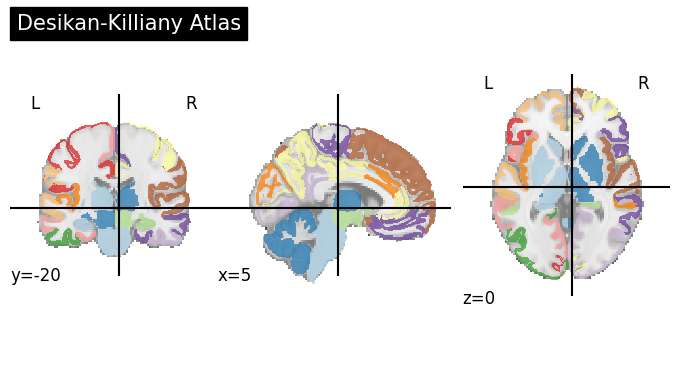

In [117]:
from nilearn import plotting

plotting.plot_roi(dk_atlas, title='Desikan-Killiany Atlas', cut_coords=(5, -20, 0), cmap='Paired', colorbar=False)

In [118]:
from nilearn.maskers import NiftiLabelsMasker
from nilearn.interfaces.fmriprep import load_confounds


fname = "/Users/brainsimulation/Desktop/nmdare-data-fmriprep/derivatives/fmriprep/sub-LEGK010/func/sub-LEGK010_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

confounds_simple, sample_mask = load_confounds(
    fname,
    strategy=["high_pass", "compcor"],
    compcor="temporal_anat_combined",
    n_compcor=10    
)

masker = NiftiLabelsMasker(
    labels_img=dk_atlas, 
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
)

bold = nib.load(fname)
print(bold.shape)

# time_series = masker.fit_transform(
#     bold,
#     confounds=confounds_simple,
#     sample_mask=sample_mask
# )

time_series = masker.fit_transform(bold)

time_series.shape

(47, 58, 45, 260)


(260, 87)

0.4757382

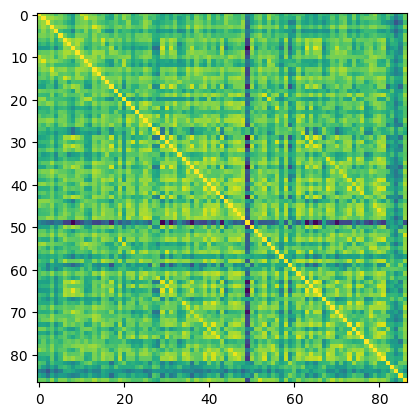

In [119]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation', standardize='zscore_sample')

correlation_matrix = correlation_measure.fit_transform([time_series])[0]

import matplotlib.pyplot as plt
plt.imshow(correlation_matrix)
np.mean(correlation_matrix)

In [120]:
time_series.shape

(260, 87)

In [121]:
window_size = 40
window_step = 5

all_fcs = []
for i in range(0, time_series.shape[0] - window_size, window_step):
    window_ts = time_series[i:i + window_size, :]

    correlation_measure = ConnectivityMeasure(kind='correlation', standardize='zscore_sample')

    fc = correlation_measure.fit_transform([window_ts])[0]
    all_fcs.append(fc)
    

In [122]:
def FCuCorrelation(FC1, FC2, fisher=True):
    """
    Computes the correlation between the upper triangular parts of two FC matrices.

    Parameters
    ----------
    FC1 : ndarray
        The first functional connectivity matrix (N, N).
    FC2 : ndarray
        The second functional connectivity matrix (N, N).
    fisher : bool, optional (default=True)
        If True, applies Fisher's z-transformation to the upper triangular elements.

    Returns
    -------
    float
        Pearson correlation between the upper triangular elements of FC1 and FC2.
    """
    u_idx = np.triu_indices_from(FC1, k=1)
    FCu1 = FC1.copy()[u_idx]
    FCu2 = FC2.copy()[u_idx]
    if fisher:
        FCu1 = np.arctanh(FCu1)
        FCu2 = np.arctanh(FCu2)
    FC_corr_upper = np.corrcoef(FCu1, FCu2)[0, 1]
    return FC_corr_upper

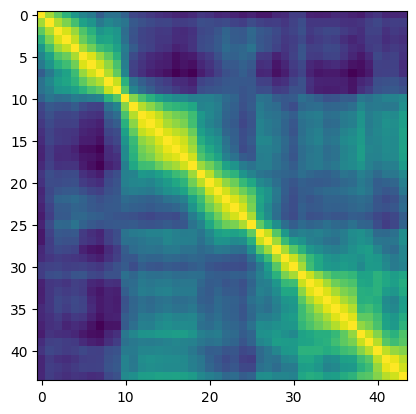

In [123]:
n_fcs = len(all_fcs)

FDC = np.zeros((n_fcs, n_fcs))
for i in range(n_fcs):
    for j in range(n_fcs):
        FDC[i, j] = FCuCorrelation(all_fcs[i], all_fcs[j])

plt.imshow(FDC)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  6.,  0.,  8., 12., 16., 22., 32., 38., 38.,
        44., 50., 36., 48., 70., 40., 40., 48., 52., 52., 58., 58., 48.,
        46., 52., 38., 48., 62., 40., 60., 40., 46., 52., 38., 36., 28.,
        24., 34., 26., 18., 28., 26., 22.,  4., 14., 22., 16.,  4., 12.,
        22.,  8., 12., 10., 14., 10., 16.,  6.,  8., 12., 14.,  8., 14.,
        18.,  8.,  8., 14., 12., 20.,  6.,  0., 44.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.

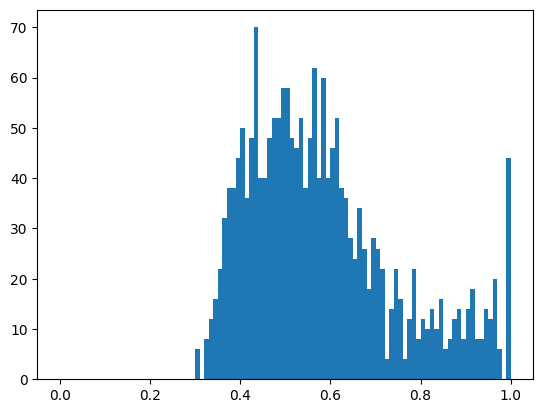

In [124]:
fcd_flattened = FDC.flatten()
plt.hist(fcd_flattened, bins=100, range=(0, 1))